In [255]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datasets import get_datasets, get_shiller
import matplotlib.pyplot as plt
import random

time_horizon = 40

data = get_datasets()
data['returns_with_dividends'] = data['simple_return'] + data['dividend_return']

[*********************100%***********************]  1 of 1 completed


In [437]:
time_horizon = 40

# Define the horizons and the number of portfolios
horizons = np.arange(1, time_horizon+1, 1)
n_portfolios = len(data) - (time_horizon * 12) + 1


# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    # Calculate the number of months in the specified time horizon
    months_in_horizon = horizon * 12

    # Loop through each portfolio and calculate the cumulative returns
    print(h_idx, horizon, months_in_horizon, n_portfolios)

0 1 12 652
1 2 24 652
2 3 36 652
3 4 48 652
4 5 60 652
5 6 72 652
6 7 84 652
7 8 96 652
8 9 108 652
9 10 120 652
10 11 132 652
11 12 144 652
12 13 156 652
13 14 168 652
14 15 180 652
15 16 192 652
16 17 204 652
17 18 216 652
18 19 228 652
19 20 240 652
20 21 252 652
21 22 264 652
22 23 276 652
23 24 288 652
24 25 300 652
25 26 312 652
26 27 324 652
27 28 336 652
28 29 348 652
29 30 360 652
30 31 372 652
31 32 384 652
32 33 396 652
33 34 408 652
34 35 420 652
35 36 432 652
36 37 444 652
37 38 456 652
38 39 468 652
39 40 480 652


In [438]:
# Define the investment horizon
time_horizon = 40

# Define the horizons and the number of portfolios
horizons = np.arange(1, time_horizon+1, 1)
n_portfolios = len(data) - (time_horizon * 12) + 1

# Create arrays to store the portfolio results
cum_market_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_risk_free_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_dividends_returns_distributions = np.zeros((len(horizons), n_portfolios))
starting_dates = []

# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    # Calculate the number of months in the specified time horizon
    months_in_horizon = horizon * 12

    # Loop through each portfolio and calculate the cumulative returns
    for i in range(n_portfolios):
        start_idx = i
        end_idx = start_idx + months_in_horizon

        market_returns = data.loc[start_idx:end_idx-1, 'simple_return'].values
        risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
        dividends_returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

        cum_market_returns_portfolios = np.prod(1 + market_returns) - 1
        cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1
        cum_dividends_returns_portfolios = np.prod(1 + dividends_returns) - 1

        # Store the cumulative return distributions for the current investment horizon
        cum_market_returns_distributions[h_idx, i] = cum_market_returns_portfolios
        cum_risk_free_returns_distributions[h_idx, i] = cum_risk_free_returns_portfolios
        cum_dividends_returns_distributions[h_idx, i] = cum_dividends_returns_portfolios
        starting_dates.append(data.loc[start_idx, 'Date'])

# Convert the list of starting dates to a numpy array
starting_dates = np.array(starting_dates)

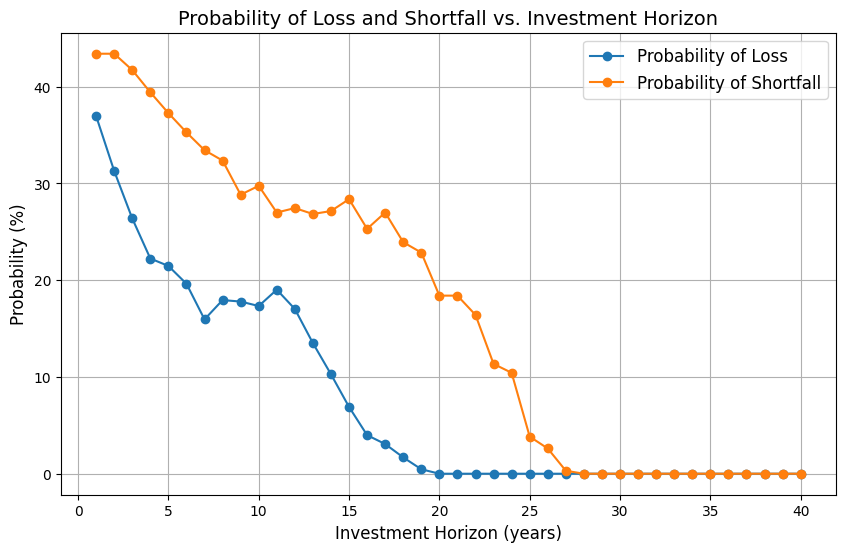

In [656]:
import matplotlib.pyplot as plt

# Calculate excess returns
excess_returns = cum_dividends_returns_distributions - cum_risk_free_returns_distributions

# Calculate the probability of loss
prob_loss = (excess_returns < 0).mean(axis=1) * 100

# Calculate the probability of performing worse than the risk-free rate
prob_worse_than_rf = (excess_returns < cum_risk_free_returns_distributions).mean(axis=1) * 100

# Set the figure size to make it wider
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the probabilities
plt.plot(horizons, prob_loss, label='Probability of Loss', marker='o')
plt.plot(horizons, prob_worse_than_rf, label='Probability of Shortfall', marker='o')
plt.xlabel('Investment Horizon (years)', fontsize=12)
plt.ylabel('Probability (%)', fontsize=12)
plt.title('Probability of Loss and Shortfall vs. Investment Horizon', fontsize=14)
plt.tick_params(labelsize=10)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('portfolios/probability_shortfall')
plt.show()


In [657]:
import numpy as np
import pandas as pd

# Define arrays to store results
mean_annualized_risk_free = np.zeros(len(horizons))
mean_cumulative_risk_free = np.zeros(len(horizons))

mean_cumulative_returns = np.zeros(len(horizons))
mean_annualized_returns = np.zeros(len(horizons))

std_cumulative_returns = np.zeros(len(horizons))
std_annualized_returns = np.zeros(len(horizons))

# Avoid division by zero
epsilon = 1e-8

def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

for h_idx, horizon in enumerate(horizons):

    cumulative_returns = cum_dividends_returns_distributions[h_idx]
    cumulative_risk_free = cum_risk_free_returns_distributions[h_idx]

    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)

    mean_annualized_risk_free[h_idx] = np.mean(annualized_risk_free)
    mean_cumulative_risk_free[h_idx] = np.mean(cumulative_risk_free)

    mean_cumulative_returns[h_idx] = np.mean(cumulative_returns)
    mean_annualized_returns[h_idx] = np.mean(annualized_returns)
   
    std_cumulative_returns[h_idx] = np.std(cumulative_returns)
    std_annualized_returns[h_idx] = np.std(annualized_returns)

# Convert returns to DataFrame
statistics = pd.DataFrame({
    'Cumulative Risk Free Returns': mean_cumulative_risk_free,
    'Average Annualized Risk Free Return': mean_annualized_risk_free,
   
    'Mean Cumulative Returns': mean_cumulative_returns,
    'Mean Annualized Returns': mean_annualized_returns,
    
    'Std Dev of Cumulative Returns': std_cumulative_returns,
    'Std Dev of Annualized Returns': std_annualized_returns,
}, index=horizons)


selected_statistics = (statistics.loc[[1, 5, 10, 15, 20, 30, 40], ['Average Annualized Risk Free Return', 'Mean Annualized Returns', 'Std Dev of Annualized Returns']] * 100).round(2)

# Generate a latex table
latex_table = selected_statistics.to_latex()

# Print the latex table
print(latex_table)



\begin{tabular}{lrrr}
\toprule
{} &  Average Annualized Risk Free Return &  Mean Annualized Returns &  Std Dev of Annualized Returns \\
\midrule
1  &                                 3.24 &                    10.81 &                          22.84 \\
5  &                                 3.45 &                    10.37 &                           8.02 \\
10 &                                 3.73 &                    10.72 &                           5.35 \\
15 &                                 3.96 &                    11.23 &                           4.19 \\
20 &                                 4.19 &                    11.56 &                           3.34 \\
30 &                                 4.46 &                    11.23 &                           1.28 \\
40 &                                 4.52 &                    10.92 &                           0.96 \\
\bottomrule
\end{tabular}



/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_59522/936694831.py:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = selected_statistics.to_latex()


In [658]:
## Descriptive statistics
import numpy as np
import pandas as pd

# Define arrays to store results
mean_annualized_risk_free = np.zeros(len(horizons))
mean_cumulative_risk_free = np.zeros(len(horizons))

min_cumulative_returns = np.zeros(len(horizons))
percentile_1_cumulative_returns = np.zeros(len(horizons))
percentile_10_cumulative_returns = np.zeros(len(horizons))
percentile_25_cumulative_returns = np.zeros(len(horizons))
mean_cumulative_returns = np.zeros(len(horizons))
percentile_75_cumulative_returns = np.zeros(len(horizons))
percentile_90_cumulative_returns = np.zeros(len(horizons))
percentile_99_cumulative_returns = np.zeros(len(horizons))
max_cumulative_returns = np.zeros(len(horizons))
min_annualized_returns = np.zeros(len(horizons))
percentile_1_annualized_returns = np.zeros(len(horizons))
percentile_10_annualized_returns = np.zeros(len(horizons))
percentile_25_annualized_returns = np.zeros(len(horizons))
mean_annualized_returns = np.zeros(len(horizons))
percentile_75_annualized_returns = np.zeros(len(horizons))
percentile_90_annualized_returns = np.zeros(len(horizons))
percentile_99_annualized_returns = np.zeros(len(horizons))
max_annualized_returns = np.zeros(len(horizons))

# Avoid division by zero
epsilon = 1e-8

def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

for h_idx, horizon in enumerate(horizons):

    cumulative_returns = cum_dividends_returns_distributions[h_idx]
    cumulative_risk_free = cum_risk_free_returns_distributions[h_idx]

    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)

    mean_annualized_risk_free[h_idx] = np.mean(annualized_risk_free)
    mean_cumulative_risk_free[h_idx] = np.mean(cumulative_risk_free)

    # Calculate cumulative returns statistics
    min_cumulative_returns[h_idx] = np.min(cumulative_returns)
    percentile_1_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 1)
    percentile_10_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 10)
    percentile_25_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 25)
    mean_cumulative_returns[h_idx] = np.mean(cumulative_returns)
    percentile_75_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 75)
    percentile_90_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 90)
    percentile_99_cumulative_returns[h_idx] = np.percentile(cumulative_returns, 99)
    max_cumulative_returns[h_idx] = np.max(cumulative_returns)

    # Calculate annualized returns statistics
    min_annualized_returns[h_idx] = np.min(annualized_returns)
    percentile_1_annualized_returns[h_idx] = np.percentile(annualized_returns, 1)
    percentile_10_annualized_returns[h_idx] = np.percentile(annualized_returns, 10)
    percentile_25_annualized_returns[h_idx] = np.percentile(annualized_returns, 25)
    mean_annualized_returns[h_idx] = np.mean(annualized_returns)
    percentile_75_annualized_returns[h_idx] = np.percentile(annualized_returns, 75)
    percentile_90_annualized_returns[h_idx] = np.percentile(annualized_returns, 90)
    percentile_99_annualized_returns[h_idx] = np.percentile(annualized_returns, 99)
    max_annualized_returns[h_idx] = np.max(annualized_returns)

    # Find the index of the maximum cumulative return
    max_return_index = np.argmax(cumulative_returns)
    max_return_start_date = starting_dates[max_return_index]
    min_return_index = np.argmin(cumulative_returns)
    min_return_start_date = starting_dates[min_return_index]

    # Print the corresponding year for the minimum cumulative return


    # Print the corresponding year for the maximum cumulative return
    print(f"Maximum Cumulative Return with {horizon}-year horizon: {max_cumulative_returns[h_idx]}, Start Date: {max_return_start_date}")
    print(f"Minimum Cumulative Return with {horizon}-year horizon: {min_cumulative_returns[h_idx]}, Start Date: {min_return_start_date}")


# Convert returns to DataFrame
statistics = pd.DataFrame({
    'Cumulative Risk Free Returns': mean_cumulative_risk_free,
    'Average Annualized Risk Free Return': mean_annualized_risk_free,
    'Minimum Cumulative Returns': min_cumulative_returns,
    '1st Percentile Cumulative Returns': percentile_1_cumulative_returns,
    '10th Percentile Cumulative Returns': percentile_10_cumulative_returns,
    '25th Percentile Cumulative Returns': percentile_25_cumulative_returns,
    'Mean Cumulative Returns': mean_cumulative_returns,
    '75th Percentile Cumulative Returns': percentile_75_cumulative_returns,
    '90th Percentile Cumulative Returns': percentile_90_cumulative_returns,
    '99th Percentile Cumulative Returns': percentile_99_cumulative_returns,
    'Maximum Cumulative Returns': max_cumulative_returns,
    'Minimum Annualized Returns': min_annualized_returns,
    '1st Percentile Annualized Returns': percentile_1_annualized_returns,
    '10th Percentile Annualized Returns': percentile_10_annualized_returns,
    '25th Percentile Annualized Returns': percentile_25_annualized_returns,
    'Mean Annualized Returns': mean_annualized_returns,
    '75th Percentile Annualized Returns': percentile_75_annualized_returns,
    '90th Percentile Annualized Returns': percentile_90_annualized_returns,
    '99th Percentile Annualized Returns': percentile_99_annualized_returns,
    'Maximum Annualized Returns': max_annualized_returns,
}, index=horizons)

print(statistics)


Maximum Cumulative Return with 1-year horizon: 1.4025771721019846, Start Date: 1932-08-31 00:00:00
Minimum Cumulative Return with 1-year horizon: -0.6218502972109035, Start Date: 1931-07-31 00:00:00
Maximum Cumulative Return with 2-year horizon: 1.3496177278175807, Start Date: 1932-07-31 00:00:00
Minimum Cumulative Return with 2-year horizon: -0.7421338744392005, Start Date: 1930-07-31 00:00:00
Maximum Cumulative Return with 3-year horizon: 1.7246391065479525, Start Date: 1933-04-30 00:00:00
Minimum Cumulative Return with 3-year horizon: -0.7854526072512696, Start Date: 1929-08-31 00:00:00
Maximum Cumulative Return with 4-year horizon: 2.7805636864638195, Start Date: 1932-08-31 00:00:00
Minimum Cumulative Return with 4-year horizon: -0.6817598655832653, Start Date: 1929-04-30 00:00:00
Maximum Cumulative Return with 5-year horizon: 3.1979282162845513, Start Date: 1932-08-31 00:00:00
Minimum Cumulative Return with 5-year horizon: -0.6113252911234138, Start Date: 1929-10-31 00:00:00
Maxim

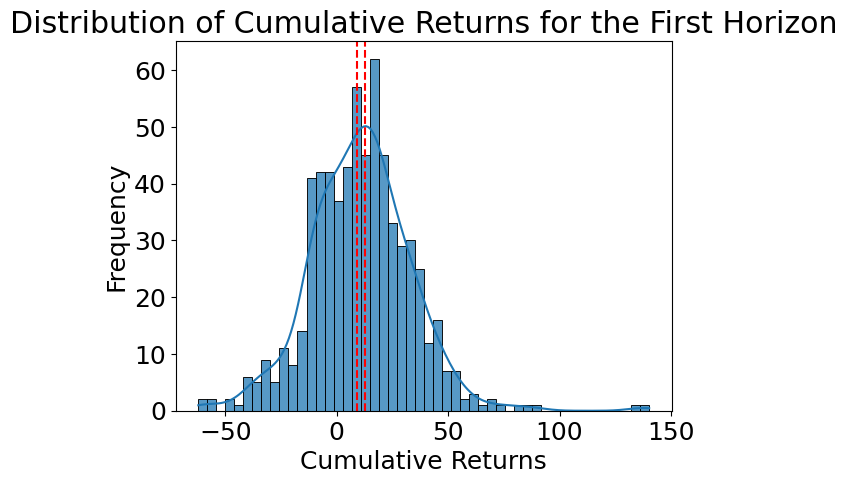

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Annualized Returns} & \multicolumn{2}{l}{Cumulative Returns} \\
{} &       Lower 95\% CI & Upper 95\% CI &       Lower 95\% CI & Upper 95\% CI \\
\midrule
1  &               9.05 &        12.56 &               9.05 &        12.56 \\
5  &               9.75 &        10.98 &              67.64 &        76.73 \\
10 &              10.31 &        11.13 &             195.04 &       215.87 \\
15 &              10.91 &        11.56 &             444.22 &       489.02 \\
20 &              11.30 &        11.81 &             896.86 &       984.14 \\
30 &              11.14 &        11.33 &            2413.45 &      2553.52 \\
40 &              10.85 &        11.00 &            6414.22 &      6741.70 \\
\bottomrule
\end{tabular}



/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_59522/3017592273.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(selected_ci_df.to_latex())


In [659]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define arrays to store results
ci_low_annualized = np.zeros(len(horizons))
ci_high_annualized = np.zeros(len(horizons))
ci_low_cumulative = np.zeros(len(horizons))
ci_high_cumulative = np.zeros(len(horizons))
risk_free_rate = np.zeros(len(horizons))

def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

for h_idx, horizon in enumerate(horizons):
    cumulative_returns = cum_dividends_returns_distributions[h_idx]
    cumulative_risk_free = cum_risk_free_returns_distributions[h_idx]
    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)
    risk_free_rate[h_idx] = np.mean(annualized_risk_free)
    ci_low_annualized[h_idx], ci_high_annualized[h_idx] = stats.t.interval(0.95, len(annualized_returns)-1, loc=np.mean(annualized_returns), scale=stats.sem(annualized_returns))
    ci_low_cumulative[h_idx], ci_high_cumulative[h_idx] = stats.t.interval(0.95, len(cumulative_returns)-1, loc=np.mean(cumulative_returns), scale=stats.sem(cumulative_returns))

    if h_idx == 0:
        sns.histplot(100 * cumulative_returns, bins=50, kde=True, alpha=0.75)
        plt.axvline(x=100*ci_low_cumulative[h_idx], color='r', linestyle='--')
        plt.axvline(x=100*ci_high_cumulative[h_idx], color='r', linestyle='--')
        plt.title('Distribution of Cumulative Returns for the First Horizon')
        plt.xlabel('Cumulative Returns')
        plt.ylabel('Frequency')
        plt.show()

# Convert results to DataFrame
ci_df = pd.DataFrame({
    'Lower 95% CI of Annualized Returns': ci_low_annualized,
    'Upper 95% CI of Annualized Returns': ci_high_annualized,

    'Lower 95% CI of Cumulative Returns': ci_low_cumulative,
    'Upper 95% CI of Cumulative Returns': ci_high_cumulative,
}, index=horizons)

modified_ci_df = ci_df.copy()
modified_ci_df.columns = pd.MultiIndex.from_tuples([
    ('Annualized Returns', 'Lower 95% CI'),
    ('Annualized Returns', 'Upper 95% CI'),
    ('Cumulative Returns', 'Lower 95% CI'),
    ('Cumulative Returns', 'Upper 95% CI')
])

# Print results
selected_rows = [0, 4, 9, 14, 19, 29, 39]
selected_ci_df = round( modified_ci_df.iloc[selected_rows]*100,2)


# Print the modified table
print(selected_ci_df.to_latex())



In [660]:
import pandas as pd

# Define the desired observations for the table
obs_indices = [0, 4, 9, 14, 19, 29, 39]

# Create a DataFrame with the desired observations
table_data = pd.DataFrame(columns=['Horizon', 'Cumulative Returns', 'Annualized Returns'])
table_data['Horizon'] = [horizons[i] for i in obs_indices]
table_data['Cumulative Returns'] = [mean_cumulative_risk_free[i] * 100 for i in obs_indices]
table_data['Annualized Returns'] = [mean_annualized_risk_free[i] * 100 for i in obs_indices]

# Format the table
table_data['Cumulative Returns'] = table_data['Cumulative Returns'].apply(lambda x: '{:.1f}'.format(x))
table_data['Annualized Returns'] = table_data['Annualized Returns'].apply(lambda x: '{:.1f}'.format(x))

# Print the LaTeX table
print("\\begin{table}[ht]")
print("\\centering")
print("\\caption{Cumulative and Annualized Returns}")
print("\\begin{tabular}{c|lllllllll}")
print("\\midrule")
print("\\multicolumn{10}{c}{\\textbf{Cumulative Returns (\\%)}} \\\\")
print("\\toprule")
print("\\textbf{Horizon} & \\textbf{$r_f$} & \\textbf{1st} & \\textbf{25th} & \\textbf{50th} & \\textbf{75th} & \\textbf{99th} & \\textbf{Max} & \\textbf{Min} \\\\")
print("\\midrule")

for i in obs_indices:
    horizon = horizons[i]
    cumulative = [
        mean_cumulative_risk_free[i] * 100,
        min_cumulative_returns[i] * 100,
        percentile_1_cumulative_returns[i] * 100,
        percentile_25_cumulative_returns[i] * 100,
        mean_cumulative_returns[i] * 100,
        percentile_75_cumulative_returns[i] * 100,
        percentile_99_cumulative_returns[i] * 100,
        max_cumulative_returns[i] * 100
    ]
    cumulative = ' & '.join(['{:.1f}'.format(x) for x in cumulative])
    print(f"{horizon} & {cumulative} \\\\")

print("\\midrule")
print("\\multicolumn{10}{c}{\\textbf{Annualized Returns (\\%)}} \\\\")
print("\\toprule")
print("\\textbf{Horizon} & \\textbf{$r_f$} & \\textbf{1st} & \\textbf{25th} & \\textbf{50th} & \\textbf{75th} & \\textbf{99th} & \\textbf{Max} & \\textbf{Min} \\\\")
print("\\midrule")

for i in obs_indices:
    horizon = horizons[i]
    annualized = [
        mean_annualized_risk_free[i] * 100,
        min_annualized_returns[i] * 100,
        percentile_1_annualized_returns[i] * 100,
        percentile_25_annualized_returns[i] * 100,
        mean_annualized_returns[i] * 100,
        percentile_75_annualized_returns[i] * 100,
        percentile_99_annualized_returns[i] * 100,
        max_annualized_returns[i] * 100
        
    ]
    annualized = ' & '.join(['{:.1f}'.format(x) for x in annualized])
    print(f"{horizon} & {annualized} \\\\")

print("\\bottomrule")
print("\\end{tabular}")
print("\\end{table}")


\begin{table}[ht]
\centering
\caption{Cumulative and Annualized Returns}
\begin{tabular}{c|lllllllll}
\midrule
\multicolumn{10}{c}{\textbf{Cumulative Returns (\%)}} \\
\toprule
\textbf{Horizon} & \textbf{$r_f$} & \textbf{1st} & \textbf{25th} & \textbf{50th} & \textbf{75th} & \textbf{99th} & \textbf{Max} & \textbf{Min} \\
\midrule
1 & 3.2 & -62.2 & -42.9 & -3.3 & 10.8 & 24.3 & 69.8 & 140.3 \\
5 & 19.7 & -61.1 & -48.0 & 33.1 & 72.2 & 108.7 & 232.2 & 319.8 \\
10 & 50.4 & -33.3 & -21.9 & 97.2 & 205.5 & 328.3 & 514.4 & 580.5 \\
15 & 94.7 & -4.8 & 11.2 & 208.7 & 466.6 & 697.5 & 1136.3 & 1283.0 \\
20 & 156.3 & 50.4 & 75.6 & 404.8 & 940.5 & 1341.7 & 2464.9 & 2607.4 \\
30 & 331.3 & 808.0 & 998.1 & 1801.1 & 2483.5 & 3130.2 & 4961.3 & 5413.5 \\
40 & 561.0 & 1958.2 & 2313.0 & 4881.4 & 6578.0 & 8023.9 & 11275.4 & 14003.7 \\
\midrule
\multicolumn{10}{c}{\textbf{Annualized Returns (\%)}} \\
\toprule
\textbf{Horizon} & \textbf{$r_f$} & \textbf{1st} & \textbf{25th} & \textbf{50th} & \textbf{75th} & \te

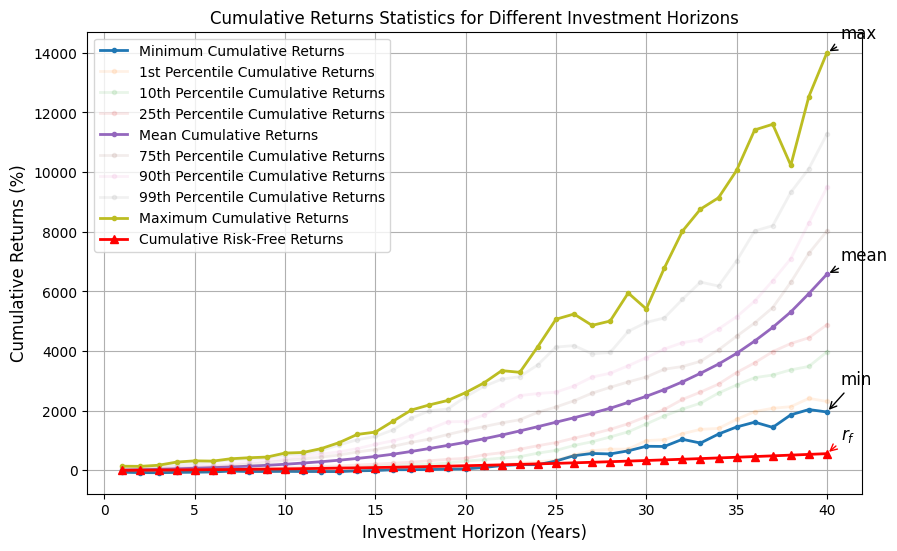

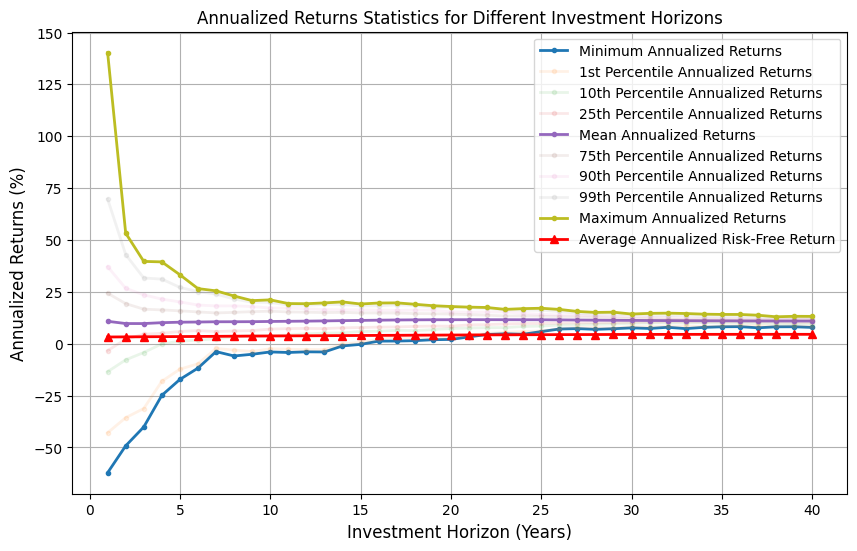

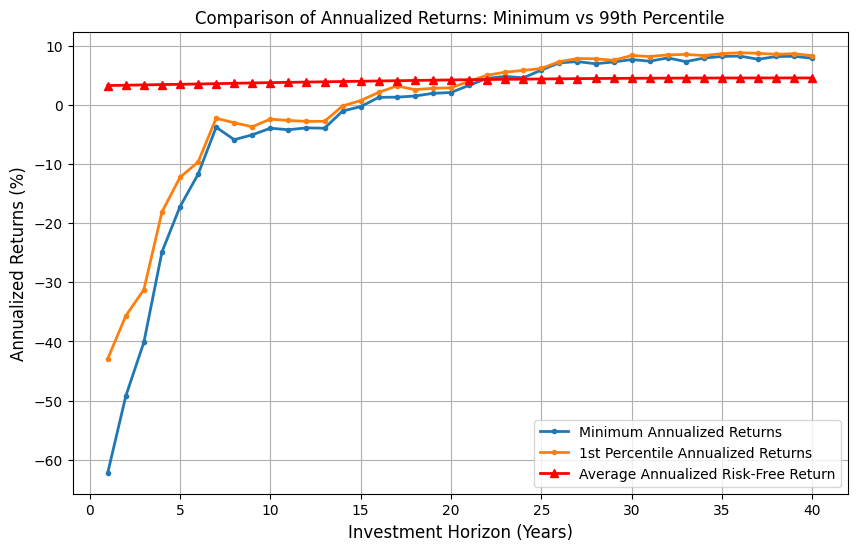

In [661]:
import matplotlib.pyplot as plt

# Plotting cumulative returns statistics with risk-free returns
plt.figure(figsize=(10, 6))
plt.plot(horizons, min_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Minimum Cumulative Returns")
plt.plot(horizons, percentile_1_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="1st Percentile Cumulative Returns")
plt.plot(horizons, percentile_10_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="10th Percentile Cumulative Returns")
plt.plot(horizons, percentile_25_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="25th Percentile Cumulative Returns")
plt.plot(horizons, mean_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Mean Cumulative Returns")
plt.plot(horizons, percentile_75_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="75th Percentile Cumulative Returns")
plt.plot(horizons, percentile_90_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="90th Percentile Cumulative Returns")
plt.plot(horizons, percentile_99_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="99th Percentile Cumulative Returns")
plt.plot(horizons, max_cumulative_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Maximum Cumulative Returns")
plt.plot(horizons, mean_cumulative_risk_free * 100, marker='^', linestyle='-', linewidth=2, markersize=6, alpha=1, color='red', label="Cumulative Risk-Free Returns")  # Line with marker "^" for risk-free returns
plt.xlabel("Investment Horizon (Years)", fontsize=12)
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Cumulative Returns Statistics for Different Investment Horizons", fontsize=12)
plt.legend(fontsize=10)
# Annotating the minimum, maximum, average, and risk-free returns
min_return_index = np.argmax(min_cumulative_returns)+1
max_return_index = np.argmax(max_cumulative_returns)

plt.annotate("min", xy=(horizons[min_return_index], min_cumulative_returns[min_return_index] * 100), xytext=(10, 20),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'),fontsize=12)

plt.annotate("max", xy=(horizons[max_return_index], max_cumulative_returns[max_return_index] * 100), xytext=(10, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'),fontsize=12)

plt.annotate("mean", xy=(horizons[-1], mean_cumulative_returns[-1] * 100), xytext=(10, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='black'), fontsize=12)

plt.annotate(r"$r_f$", xy=(horizons[-1], mean_cumulative_risk_free[-1] * 100), xytext=(10, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", color='red'),fontsize=12)

plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('portfolios/Cumulative')
plt.show()

# Plotting annualized returns statistics with risk-free returns
plt.figure(figsize=(10, 6))
plt.plot(horizons, min_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Minimum Annualized Returns")
plt.plot(horizons, percentile_1_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="1st Percentile Annualized Returns")
plt.plot(horizons, percentile_10_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="10th Percentile Annualized Returns")
plt.plot(horizons, percentile_25_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="25th Percentile Annualized Returns")
plt.plot(horizons, mean_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Mean Annualized Returns")
plt.plot(horizons, percentile_75_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="75th Percentile Annualized Returns")
plt.plot(horizons, percentile_90_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="90th Percentile Annualized Returns")
plt.plot(horizons, percentile_99_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=0.1, label="99th Percentile Annualized Returns")
plt.plot(horizons, max_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Maximum Annualized Returns")
plt.plot(horizons, mean_annualized_risk_free * 100, marker='^', linestyle='-', linewidth=2, markersize=6, alpha=1, color='red', label="Average Annualized Risk-Free Return")  # Line with marker "^" for risk-free returns
plt.xlabel("Investment Horizon (Years)", fontsize=12)
plt.ylabel("Annualized Returns (%)", fontsize=12)
plt.title("Annualized Returns Statistics for Different Investment Horizons", fontsize=12)
plt.legend(fontsize=10)

# Annotating the minimum, maximum, average, and risk-free returns
min_return_index = np.argmin(min_annualized_returns)
max_return_index = np.argmax(max_annualized_returns)

plt.grid(True)
plt.savefig('portfolios/annualized')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(horizons, min_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="Minimum Annualized Returns")
plt.plot(horizons, percentile_1_annualized_returns * 100, marker='.', linestyle='-', linewidth=2, markersize=6, alpha=1, label="1st Percentile Annualized Returns")
plt.plot(horizons, mean_annualized_risk_free * 100, marker='^', linestyle='-', linewidth=2, markersize=6, alpha=1, color='red', label="Average Annualized Risk-Free Return")  # Line with marker "^" for risk-free returns
plt.xlabel("Investment Horizon (Years)", fontsize=12)
plt.ylabel("Annualized Returns (%)", fontsize=12)
plt.title("Comparison of Annualized Returns: Minimum vs 99th Percentile", fontsize=12)
plt.legend(fontsize=10)
# Annotating the minimum, 99th percentile, and risk-free returns
min_return_index = np.argmin(min_annualized_returns)
max_return_index = np.argmax(percentile_99_annualized_returns)


plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('portfolios/risk_free')
plt.show()


In [686]:
import numpy as np

def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

def calculate_max_drawdown(cumulative_returns):
    running_max = np.maximum.accumulate(cumulative_returns)
    running_max[running_max < 1] = 1
    drawdown = (cumulative_returns)/running_max - 1
    return np.min(drawdown)

def calculate_downside_deviation(returns, required_return=0):
    diff = required_return - returns
    diff = diff[diff < 0]  # Just consider the downside
    return np.sqrt(np.mean(diff ** 2))  # Square root of the mean of the squares of the downside differences

def calculate_annualized_std_dev(returns, horizon):
    return np.std(returns) * np.sqrt(horizon)

cumulative_returns = cum_dividends_returns_distributions[0]
cumulative_risk_free = cum_risk_free_returns_distributions[0]

for h_idx, horizon in enumerate(horizons):

    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)

    max_drawdown = calculate_max_drawdown(cumulative_returns)
    std_dev = calculate_annualized_std_dev(cumulative_returns, horizon)
    downside_deviation = calculate_downside_deviation(cumulative_returns, annualized_risk_free)

    # Ratio calculations
    sterling_ratio = (annualized_returns - annualized_risk_free) / (-max_drawdown)
    sharpe_ratio = (annualized_returns - annualized_risk_free) / std_dev
    sortino_ratio = (annualized_returns - annualized_risk_free) / downside_deviation

    print('Sterling Ratio:', np.mean(sterling_ratio))
    print('Sharpe Ratio:', np.mean(sharpe_ratio))
    print('Sortino Ratio:',np.mean(sortino_ratio))


Sterling Ratio: 0.04666729944505621
Sharpe Ratio: 0.33144373016487266
Sortino Ratio: 0.279992801154644
Sterling Ratio: 0.01911651022348486
Sharpe Ratio: 0.09600431513030672
Sortino Ratio: 0.1139994616705685
Sterling Ratio: 0.011839953368324767
Sharpe Ratio: 0.048549694652046005
Sortino Ratio: 0.07009574490730858
Sterling Ratio: 0.008544225999318351
Sharpe Ratio: 0.030341697186912816
Sortino Ratio: 0.05056565457272311
Sterling Ratio: 0.006674975712386262
Sharpe Ratio: 0.0212012675123302
Sortino Ratio: 0.039447674452334665
Sterling Ratio: 0.005473602468460124
Sharpe Ratio: 0.015870651886393403
Sortino Ratio: 0.032268546932936175
Sterling Ratio: 0.00463733754144362
Sharpe Ratio: 0.0124484943522727
Sortino Ratio: 0.02729046413872081
Sterling Ratio: 0.0040220640527770255
Sharpe Ratio: 0.01009952915785623
Sortino Ratio: 0.023638327044288036
Sterling Ratio: 0.00355057280683944
Sharpe Ratio: 0.008405708131924728
Sortino Ratio: 0.02084579704194953
Sterling Ratio: 0.0031778187525513184
Sharpe Ra

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


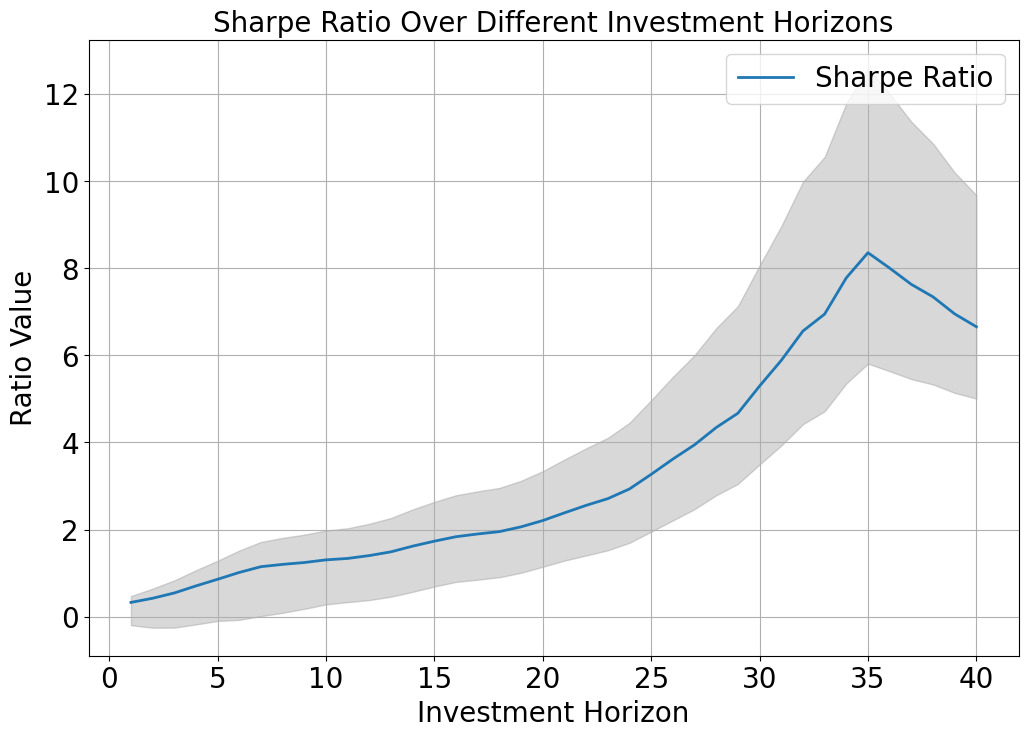

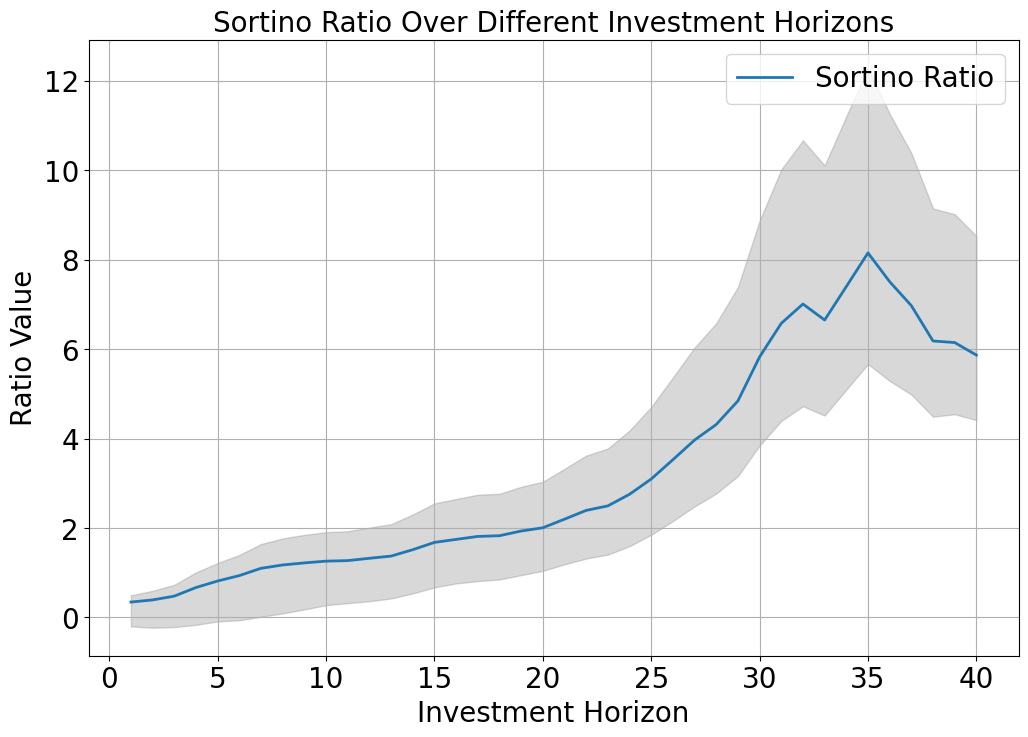

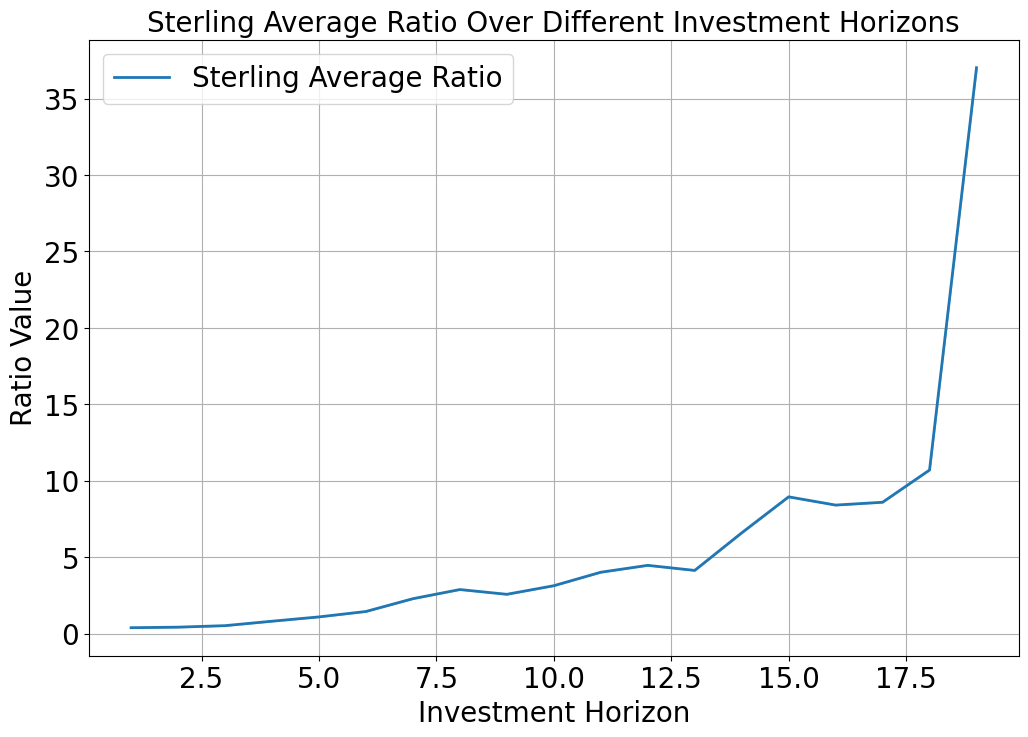

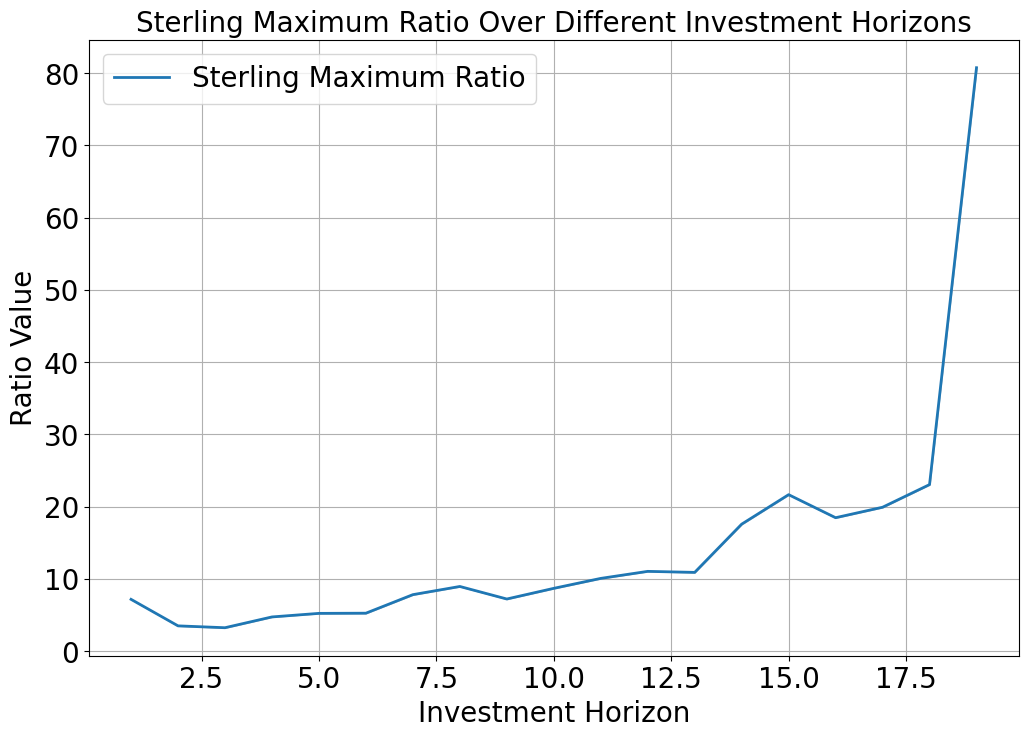

In [717]:
import numpy as np

sterling_avg_ratios = []
sterling_max_ratios = []
sharpe_ratios = []
sortino_ratios = []


def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

def calculate_max_drawdown(cumulative_returns):
    running_max = np.maximum.accumulate(cumulative_returns)
    running_max[running_max < 1] = 1
    drawdown = (cumulative_returns)/running_max - 1
    return np.min(drawdown)

def calculate_downside_deviation(returns, required_return=0):
    diff = required_return - returns
    diff = diff[diff < 0]  # Just consider the downside
    return np.sqrt(np.mean(diff ** 2))

def calculate_average_drawdown(cumulative_returns):
    running_max = np.maximum.accumulate(cumulative_returns)
    running_max[running_max < 1] = 1
    drawdowns = (cumulative_returns)/running_max - 1
    return np.mean(drawdowns)

def calculate_sharpe_ratio(returns, rf_rate=0):
    average_return = np.mean(returns)
    std_dev = np.std(returns)
    return (average_return - rf_rate) / std_dev

def calculate_semi_std(data):
    mean = np.mean(data)
    squared_diff = (data - mean) ** 2
    semi_variance = np.mean(squared_diff[data < mean])
    semi_std = np.sqrt(semi_variance)
    return semi_std

def calculate_sortino_ratio(returns, required_return=0, rf_rate=0):
    average_return = np.mean(returns)
    semi_std = calculate_semi_std(returns)
    return (average_return - rf_rate) / semi_std

sharpe_min_values = []
sharpe_max_values = []
sortino_min_values = []
sortino_max_values = []
sterling_avg_min_values = []
sterling_avg_max_values = []
sterling_max_min_values = []
sterling_max_max_values = []

for h_idx, horizon in enumerate(horizons):
    cumulative_returns = cum_dividends_returns_distributions[h_idx]
    cumulative_risk_free = cum_risk_free_returns_distributions[h_idx]

    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)

    max_drawdown = calculate_max_drawdown(cumulative_returns)
    average_drawdown = calculate_average_drawdown(cumulative_returns)

    std_dev = np.std(annualized_returns)
    downside_deviation = calculate_downside_deviation(annualized_returns, annualized_risk_free)

    # Ratio calculations
    sterling_max_ratio = (annualized_returns - annualized_risk_free) / (-max_drawdown)
    sterling_avg_ratio = (annualized_returns - annualized_risk_free) / (-average_drawdown)

    sharpe_ratio = calculate_sharpe_ratio(annualized_returns, rf_rate=annualized_risk_free)
    sortino_ratio = calculate_sortino_ratio(annualized_returns, required_return=annualized_risk_free, rf_rate=annualized_risk_free)

    excess_returns = annualized_returns-annualized_risk_free
    downside_returns = np.array([r for r in excess_returns if r <= 0])
    downside_deviation = np.sqrt(np.mean(downside_returns**2))

    # Calculate the average and maximum excess returns
    average_excess_return = np.mean(excess_returns)
    max_excess_return = np.max(excess_returns)

    # Calculate the average and maximum Sterling Ratios
    average_sterling_ratio = average_excess_return / downside_deviation
    max_sterling_ratio = max_excess_return / downside_deviation

   
    sharpe_ratios.append(np.mean(sharpe_ratio))
    sharpe_min_values.append(np.min(sharpe_ratio))
    sharpe_max_values.append(np.max(sharpe_ratio))

    sortino_ratios.append(np.mean(sortino_ratio))
    sortino_min_values.append(np.min(sortino_ratio))
    sortino_max_values.append(np.max(sortino_ratio))

    sterling_avg_ratios.append(np.mean(average_sterling_ratio))
    sterling_max_ratios.append(np.mean(max_sterling_ratio))


    sterling_avg_min_values.append(np.min(average_sterling_ratio))
    sterling_avg_max_values.append(np.max(average_sterling_ratio))

    sterling_max_min_values.append(np.min(max_sterling_ratio))
    sterling_max_max_values.append(np.max(max_sterling_ratio))

plt.rcParams.update({'font.size': 18})


# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Plot Sharpe Ratio with shaded area to represent the variability
ax.plot(horizons, sharpe_ratios, label='Sharpe Ratio', linewidth=2)
ax.fill_between(horizons, sharpe_min_values, sharpe_max_values, color='gray', alpha=0.3)

# Set titles and labels
ax.set_title('Sharpe Ratio Over Different Investment Horizons', fontsize=20)
ax.set_xlabel('Investment Horizon', fontsize=20)
ax.set_ylabel('Ratio Value', fontsize=20)

# Display legend
ax.legend(fontsize=20)

plt.grid(True)
plt.savefig('portfolios/Sharpe')
plt.show()

# Create figure and axis for Sortino Ratio
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Plot Sortino Ratio with shaded area to represent the variability
ax.plot(horizons, sortino_ratios, label='Sortino Ratio', linewidth=2)
ax.fill_between(horizons, sortino_min_values, sortino_max_values, color='gray', alpha=0.3)

# Set titles and labels
ax.set_title('Sortino Ratio Over Different Investment Horizons', fontsize=20)
ax.set_xlabel('Investment Horizon', fontsize=20)
ax.set_ylabel('Ratio Value', fontsize=20)

# Display legend
ax.legend(fontsize=20)

plt.grid(True)
plt.savefig('portfolios/Sortino')
plt.show()

# Create figure and axis for Sterling Average Ratio
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Plot Sterling Average Ratio with shaded area to represent the variability
ax.plot(horizons, sterling_avg_ratios, label='Sterling Average Ratio', linewidth=2)
ax.fill_between(horizons, sterling_avg_min_values, sterling_avg_max_values, color='gray', alpha=0.3)

# Set titles and labels
ax.set_title('Sterling Average Ratio Over Different Investment Horizons', fontsize=20)
ax.set_xlabel('Investment Horizon', fontsize=20)
ax.set_ylabel('Ratio Value', fontsize=20)

# Display legend
ax.legend(fontsize=20)

plt.grid(True)
plt.savefig('portfolios/Sterling_Avg')
plt.show()

# Create figure and axis for Sterling Maximum Ratio
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Plot Sterling Maximum Ratio with shaded area to represent the variability
ax.plot(horizons, sterling_max_ratios, label='Sterling Maximum Ratio', linewidth=2)
ax.fill_between(horizons, sterling_max_min_values, sterling_max_max_values, color='gray', alpha=0.3)

# Set titles and labels
ax.set_title('Sterling Maximum Ratio Over Different Investment Horizons', fontsize=20)
ax.set_xlabel('Investment Horizon', fontsize=20)
ax.set_ylabel('Ratio Value', fontsize=20)

# Display legend
ax.legend(fontsize=20)

plt.grid(True)
plt.savefig('portfolios/Sterling_Max')
plt.show()

gg


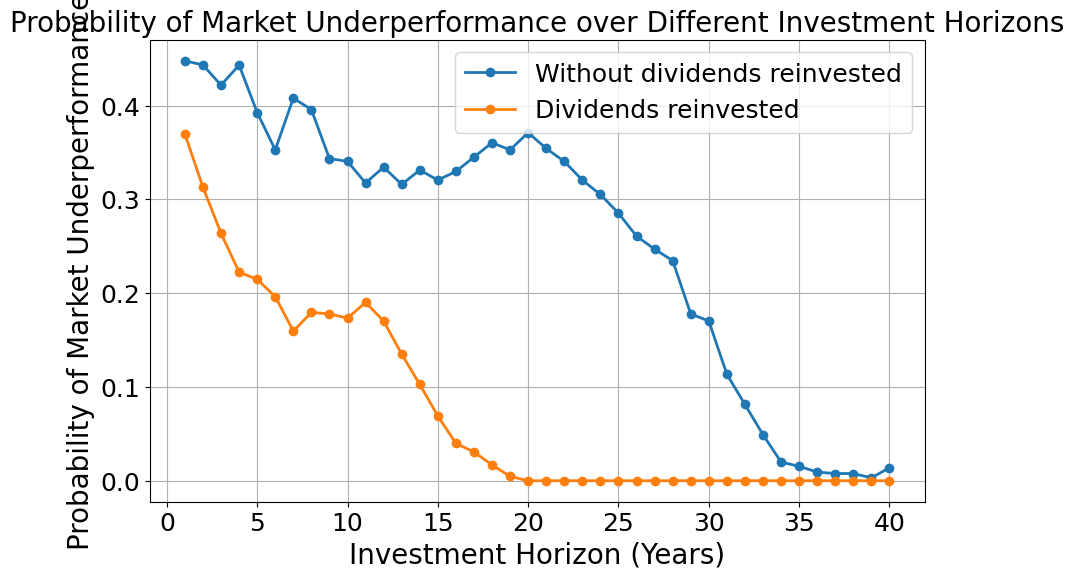

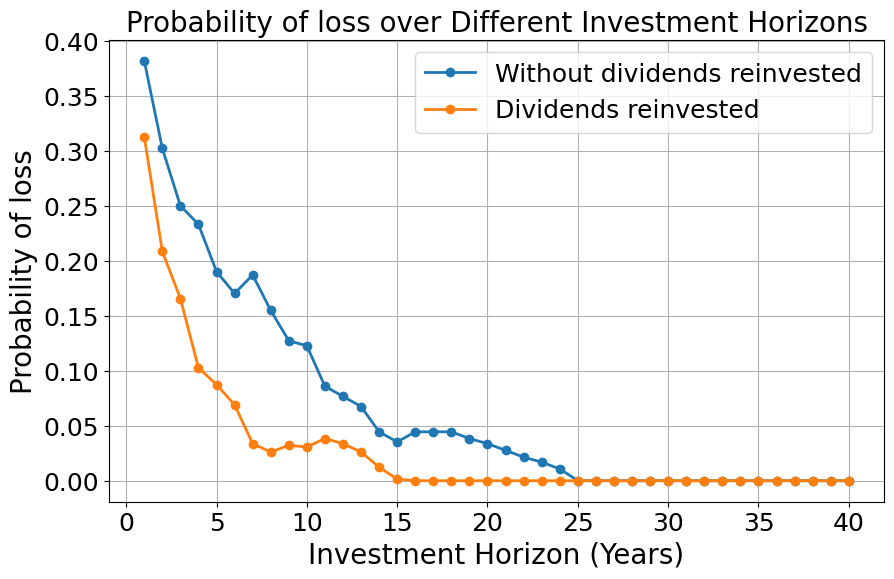

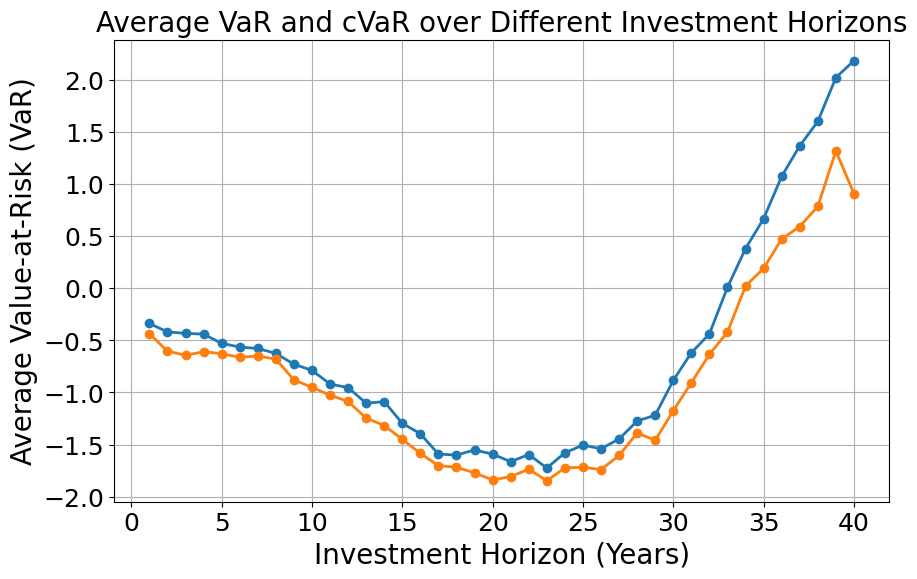

In [718]:
print('gg')
prob_underperformance_horizons = np.zeros(len(horizons))
prob_underperformance_horizons_d = np.zeros(len(horizons))
prob_loss_horizons = np.zeros(len(horizons))
prob_loss_horizons_d = np.zeros(len(horizons))
avg_var = np.zeros(len(horizons))
avg_cvar = np.zeros(len(horizons))

# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    market_returns = cum_market_returns_distributions[h_idx]
    risk_free_returns = cum_risk_free_returns_distributions[h_idx]
    dividends_returns = cum_dividends_returns_distributions[h_idx]
    
    underperformance = market_returns < risk_free_returns
    underperformance_d = dividends_returns < risk_free_returns
    
    loss = market_returns < 0
    loss_d = dividends_returns < 0
    
    diff_returns = market_returns - risk_free_returns
    var_percentage = np.percentile(diff_returns, (1 - 0.95) * 100)
    
    cvar_percentage = np.mean(diff_returns[diff_returns < var_percentage])
    
    prob_underperformance_horizons[h_idx] = np.mean(underperformance)
    prob_underperformance_horizons_d[h_idx] = np.mean(underperformance_d)
    prob_loss_horizons[h_idx] = np.mean(loss)
    prob_loss_horizons_d[h_idx] = np.mean(loss_d)
    avg_var[h_idx] = var_percentage
    avg_cvar[h_idx] = cvar_percentage

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(horizons, prob_underperformance_horizons, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Without dividends reinvested")
plt.plot(horizons, prob_underperformance_horizons_d, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Dividends reinvested")
plt.xlabel("Investment Horizon (Years)", fontsize=20)
plt.ylabel("Probability of Market Underperformance", fontsize=20)
plt.title("Probability of Market Underperformance over Different Investment Horizons", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(horizons, prob_loss_horizons, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Without dividends reinvested")
plt.plot(horizons, prob_loss_horizons_d, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Dividends reinvested")
plt.xlabel("Investment Horizon (Years)", fontsize=20)
plt.ylabel("Probability of loss", fontsize=20)
plt.title("Probability of loss over Different Investment Horizons", fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(horizons, avg_var, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Value at Risk")
plt.plot(horizons, avg_cvar, marker='o', linestyle='-', linewidth=2, markersize=6, label = "Conditional Value at Risk")
plt.xlabel("Investment Horizon (Years)", fontsize=20)
plt.ylabel("Average Value-at-Risk (VaR)", fontsize=20)
plt.title("Average VaR and cVaR over Different Investment Horizons", fontsize=20)
plt.grid(True)
plt.show()


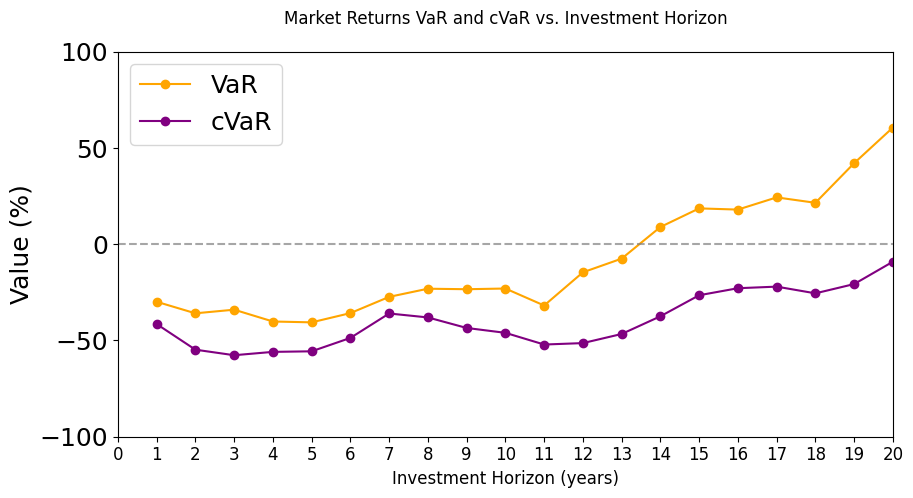

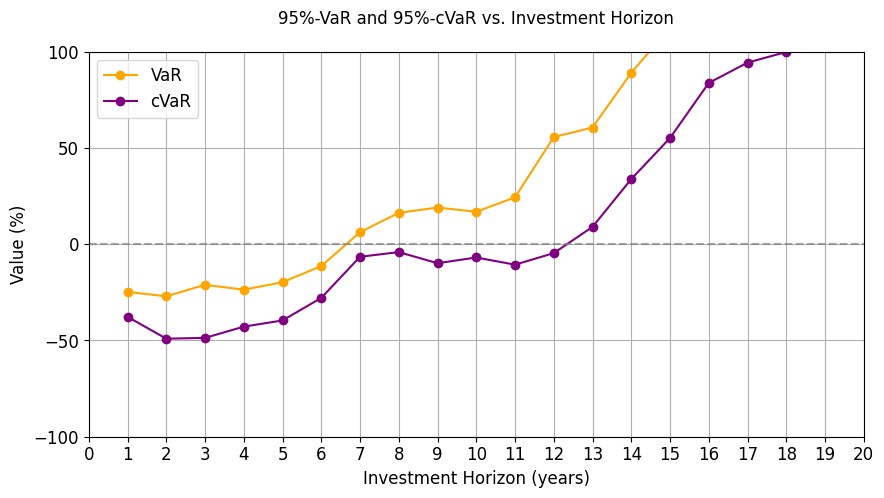

In [719]:
# Expected shortfall and VaR
def expected_shortfall(returns, confidence_level):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    shortfall = returns[returns <= var]
    return np.mean(shortfall)

var_market_values = np.zeros(len(horizons))
var_rf_values = np.zeros(len(horizons))
var_dividends_values = np.zeros(len(horizons))

es_market_values = np.zeros(len(horizons))
es_rf_values = np.zeros(len(horizons))
es_dividends_values = np.zeros(len(horizons))

confidence_level = 0.95

for idx, horizon in enumerate(horizons):
    var_market = np.percentile(100 * cum_market_returns_distributions[idx], (1 - confidence_level) * 100)
    es_market = expected_shortfall(100 * cum_market_returns_distributions[idx], confidence_level)

    var_rf = np.percentile(100 * cum_risk_free_returns_distributions[idx], (1 - confidence_level) * 100)
    es_rf = expected_shortfall(100 * cum_risk_free_returns_distributions[idx], confidence_level)

    var_dividends = np.percentile(100 * cum_dividends_returns_distributions[idx], (1 - confidence_level) * 100)
    es_dividends = expected_shortfall(100 * cum_dividends_returns_distributions[idx], confidence_level)

    var_market_values[idx] = var_market
    es_market_values[idx] = es_market
    var_rf_values[idx] = var_rf
    es_rf_values[idx] = es_rf
    var_dividends_values[idx] = var_dividends
    es_dividends_values[idx] = es_dividends

plt.figure(figsize=(10, 5))
plt.plot(horizons, var_market_values, color='orange', linestyle='-', marker='o', label='VaR')
plt.plot(horizons, es_market_values, color='purple', linestyle='-', marker='o', label='cVaR')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.xlabel('Investment Horizon (years)',fontsize = 12)
plt.ylabel('Value (%)')
plt.title('Market Returns VaR and cVaR vs. Investment Horizon', pad=20, fontsize = 12)  # Adjust the pad value
plt.legend()
plt.ylim(-100, 100)  # Set y-axis limits to -100% to 100%
plt.xlim(0, 20)  # Set x-axis limits to 0 to 20 years

# Round x-axis tick labels to 0 decimal places
plt.xticks(np.arange(0, 21, step=1), np.arange(0, 21, step=1).round(0).astype(int),fontsize = 12)

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(horizons, var_dividends_values, color='orange', linestyle='-', marker='o', label='VaR')
plt.plot(horizons, es_dividends_values, color='purple', linestyle='-', marker='o', label='cVaR')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.xlabel('Investment Horizon (years)', fontsize = 12)
plt.ylabel('Value (%)', fontsize = 12)
plt.title('95%-VaR and 95%-cVaR vs. Investment Horizon', pad=20, fontsize = 12)  # Adjust the pad value
plt.legend(fontsize = 12)
plt.ylim(-100, 100)  # Set y-axis limits to -100% to 100%
plt.xlim(0, 20)  # Set x-axis limits to 0 to 20 years

# Round x-axis tick labels to 0 decimal places
plt.xticks(np.arange(0, 21, step=1), np.arange(0, 21, step=1).round(0).astype(int), fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.savefig('portfolios/VaR_ES_95')
plt.show()



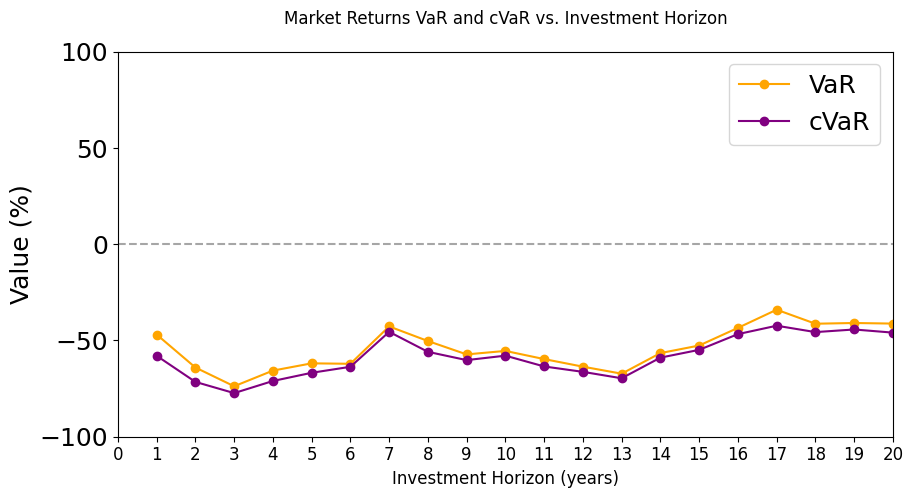

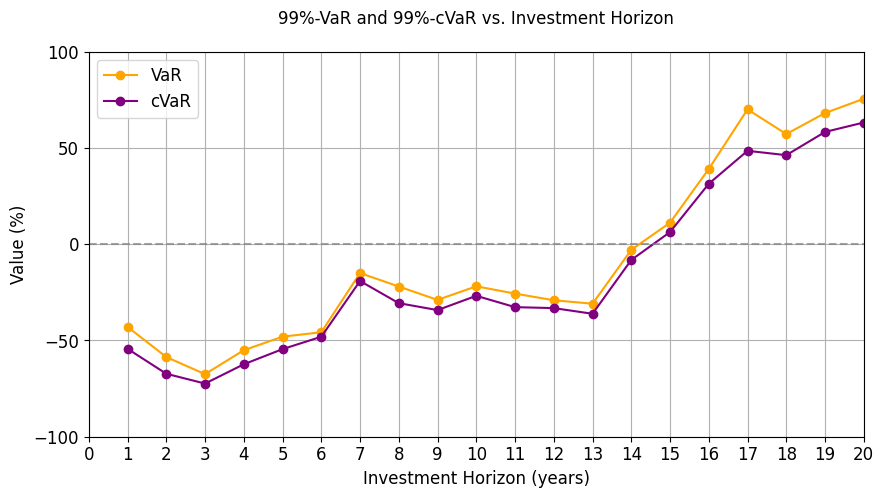

In [720]:
# Expected shortfall and VaR
def expected_shortfall(returns, confidence_level):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    shortfall = returns[returns <= var]
    return np.mean(shortfall)

var_market_values = np.zeros(len(horizons))
var_rf_values = np.zeros(len(horizons))
var_dividends_values = np.zeros(len(horizons))

es_market_values = np.zeros(len(horizons))
es_rf_values = np.zeros(len(horizons))
es_dividends_values = np.zeros(len(horizons))

confidence_level = 0.99

for idx, horizon in enumerate(horizons):
    var_market = np.percentile(100 * cum_market_returns_distributions[idx], (1 - confidence_level) * 100)
    es_market = expected_shortfall(100 * cum_market_returns_distributions[idx], confidence_level)

    var_rf = np.percentile(100 * cum_risk_free_returns_distributions[idx], (1 - confidence_level) * 100)
    es_rf = expected_shortfall(100 * cum_risk_free_returns_distributions[idx], confidence_level)

    var_dividends = np.percentile(100 * cum_dividends_returns_distributions[idx], (1 - confidence_level) * 100)
    es_dividends = expected_shortfall(100 * cum_dividends_returns_distributions[idx], confidence_level)

    var_market_values[idx] = var_market
    es_market_values[idx] = es_market
    var_rf_values[idx] = var_rf
    es_rf_values[idx] = es_rf
    var_dividends_values[idx] = var_dividends
    es_dividends_values[idx] = es_dividends

plt.figure(figsize=(10, 5))
plt.plot(horizons, var_market_values, color='orange', linestyle='-', marker='o', label='VaR')
plt.plot(horizons, es_market_values, color='purple', linestyle='-', marker='o', label='cVaR')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.xlabel('Investment Horizon (years)',fontsize = 12)
plt.ylabel('Value (%)')
plt.title('Market Returns VaR and cVaR vs. Investment Horizon', pad=20, fontsize = 12)  # Adjust the pad value
plt.legend()
plt.ylim(-100, 100)  # Set y-axis limits to -100% to 100%
plt.xlim(0, 20)  # Set x-axis limits to 0 to 20 years

# Round x-axis tick labels to 0 decimal places
plt.xticks(np.arange(0, 21, step=1), np.arange(0, 21, step=1).round(0).astype(int),fontsize = 12)

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(horizons, var_dividends_values, color='orange', linestyle='-', marker='o', label='VaR')
plt.plot(horizons, es_dividends_values, color='purple', linestyle='-', marker='o', label='cVaR')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.xlabel('Investment Horizon (years)', fontsize = 12)
plt.ylabel('Value (%)', fontsize = 12)
plt.title('99%-VaR and 99%-cVaR vs. Investment Horizon', pad=20, fontsize = 12)  # Adjust the pad value
plt.legend(fontsize = 12)
plt.ylim(-100, 100)  # Set y-axis limits to -100% to 100%
plt.xlim(0, 20)  # Set x-axis limits to 0 to 20 years

# Round x-axis tick labels to 0 decimal places
plt.xticks(np.arange(0, 21, step=1), np.arange(0, 21, step=1).round(0).astype(int), fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.savefig('portfolios/VaR_ES_99')
plt.show()



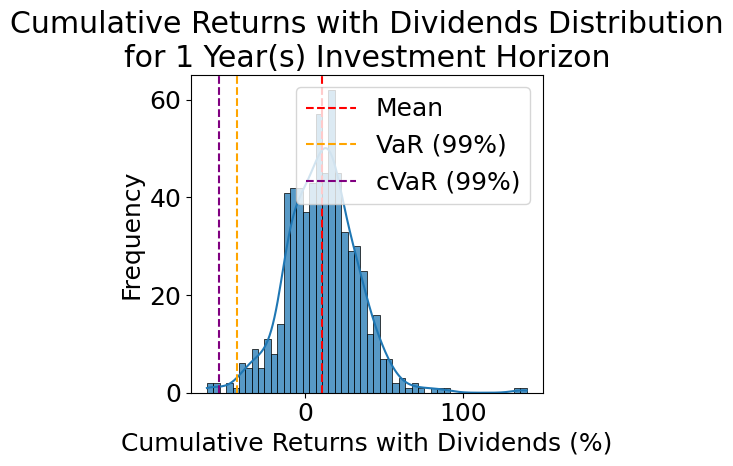

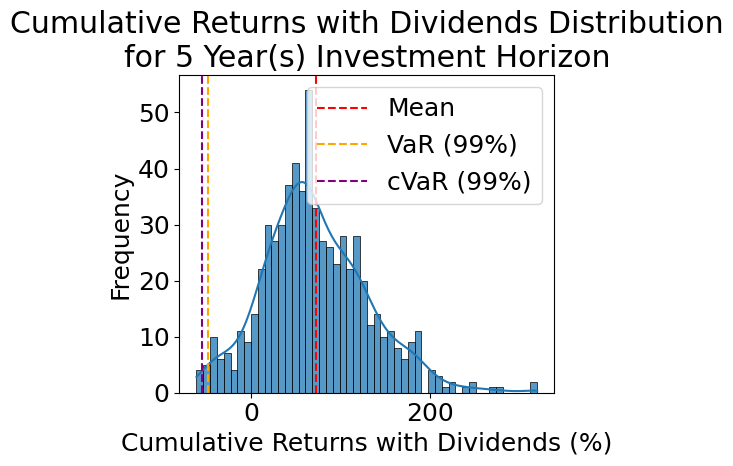

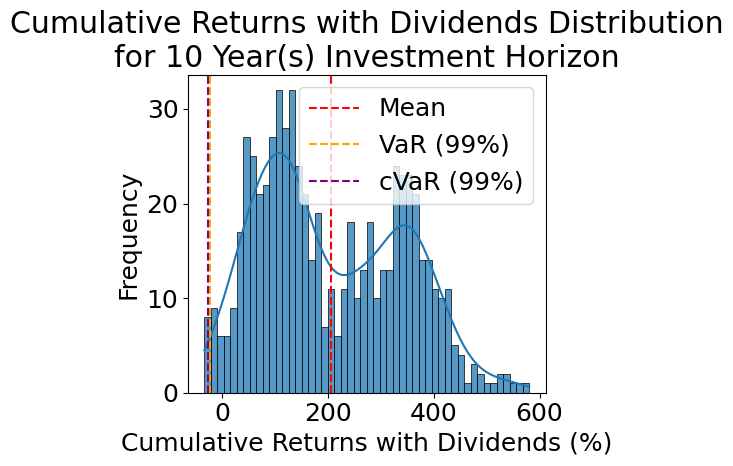

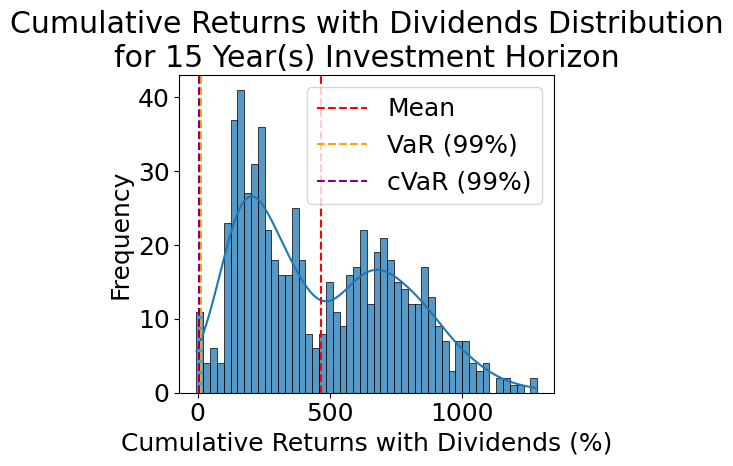

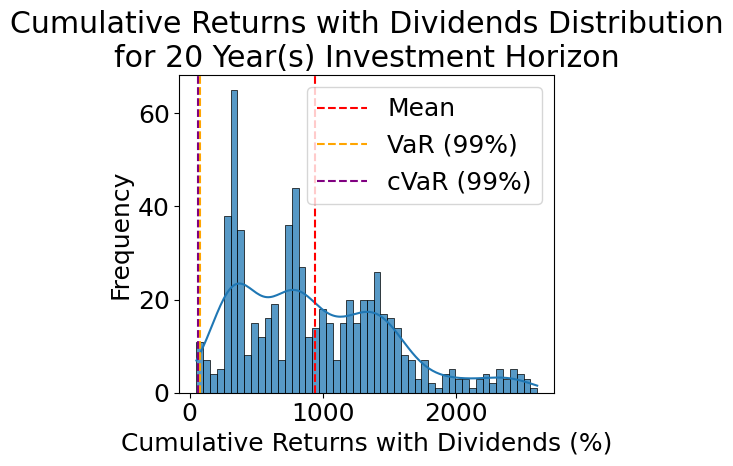

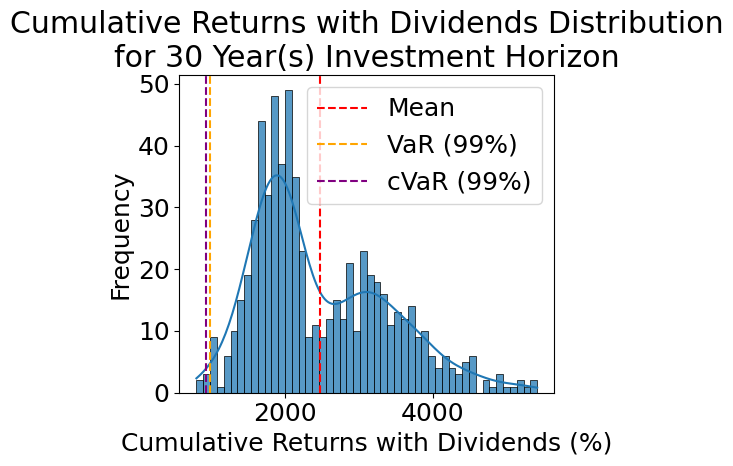

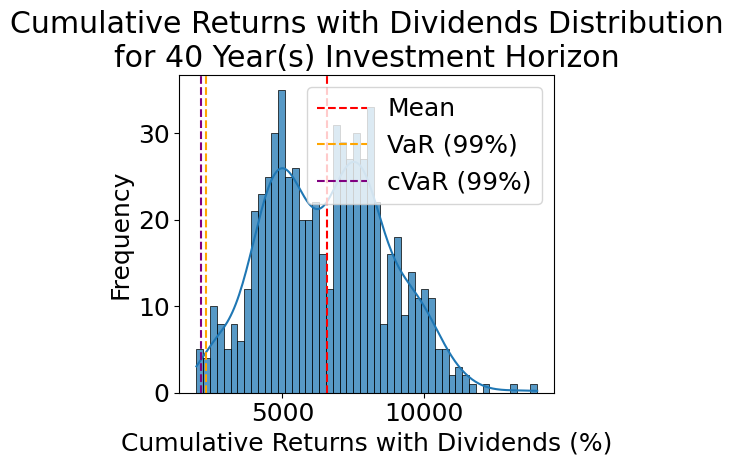

In [721]:

selected_horizons = [1, 5, 10, 15, 20,30,40]
for horizon in selected_horizons:
    idx = horizon -1
    plt.figure(figsize=(5, 5))
 
    sns.histplot(100 * cum_dividends_returns_distributions[idx], bins=50, kde=True, alpha=0.75)
    plt.axvline(100 * np.mean(cum_dividends_returns_distributions[idx]), color='red', linestyle='--', label='Mean')
    var_dividends = np.percentile(100 * cum_dividends_returns_distributions[idx], (1 - confidence_level) * 100)
    plt.axvline(var_dividends, color='orange', linestyle='--', label=f'VaR ({confidence_level * 100:.0f}%)')
    es_dividends = expected_shortfall(100 * cum_dividends_returns_distributions[idx], confidence_level)
    plt.axvline(es_dividends, color='purple', linestyle='--', label=f'cVaR ({confidence_level * 100:.0f}%)')
    plt.xlabel('Cumulative Returns with Dividends (%)')
    plt.ylabel('Frequency')
    plt.title(f'Cumulative Returns with Dividends Distribution\nfor {horizon} Year(s) Investment Horizon')
    plt.legend()

    plt.tight_layout()
    #plt.savefig('imgs/'+str(horizon) + '_year.png', bbox_inches='tight')
    plt.show()

